# Imports

In [1]:
from sinenn import SineNN, auto_n_relative_wavelengths
from metrics import amape_score

import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

# Multiwave Data Generation

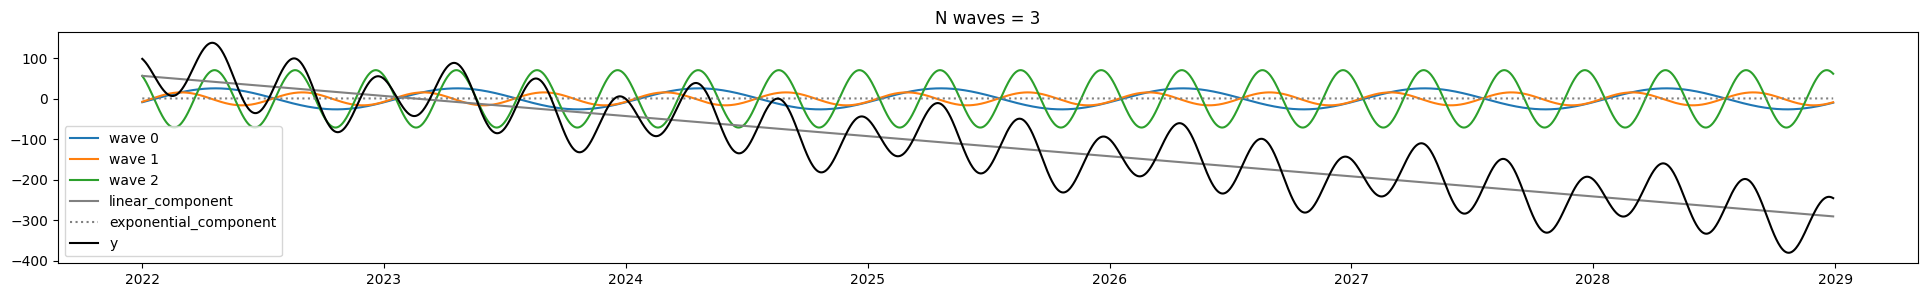

In [2]:
plt.figure(figsize=(24,3))
n_years = np.random.randint(1, 15)
period_starts = pd.Timestamp('2022-01-01')
duration_days = 365 * n_years
period_ends = period_starts + pd.Timedelta(days=duration_days)
x_date = pd.date_range(period_starts, period_ends, freq='D')[:-1]


N = 3
X = np.linspace(1, duration_days, duration_days)
a = np.random.randint(-500, 500) / (n_years * 365.25)

waves = {}
for i in range(N):
    frequency = 2 * np.pi / 365.25 * (i + 1)

    beta = 1
    elevation_power = 0
    amplitude_change_power = 0
    variation = True

    amplitude = np.random.randint(-100, 100)
    phase_shift = np.random.randint(-180, 180)
  
    
    b = np.random.randint(-100, 100)

    if not variation:
        waves[i] = amplitude * np.sin(frequency * X + phase_shift)
    else:
        waves[i] = amplitude * (X**amplitude_change_power) * np.sin(X**beta * frequency + phase_shift)

    plt.plot(x_date, waves[i], label=f'wave {i}')
y = np.sum(list(waves.values()), axis=0)
linear_component = a * X + b
exponential_component = X**elevation_power
y += linear_component
y += exponential_component
plt.plot(x_date, linear_component, color='grey', label='linear_component')
plt.plot(x_date, exponential_component, color='grey', label='exponential_component', linestyle='dotted')
plt.plot(x_date, y, color='black', label='y')
plt.legend()
plt.title(f'N waves = {N}')
plt.show()

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1,1), y, shuffle=False)

# Test the model

## Manual relative wavelengths

Model: "SineNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 1)         │       0 │ -                    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ Wave_1 (Functional) │ (None, 1)         │       5 │ input[0][0]          │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ Wave_2 (Functional) │ (None, 1)         │       5 │ input[0][0]          │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ Wave_3 (Functional) │ (None, 1)         │       5 │ input[0][0]          │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ add_waves (Add)     │ (None, 1)         │       0 │ Wave_1[0][0],        │
│                     │                   │         │ Wave_2[0][0],        │
│                     │                   │         │ Wave_3[0][0]         │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ Trend (Functional)  │ (None, 1)         │       4 │ input[0][0]          │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ waves_output        │ (None, 1)         │       0 │ add_waves[0][0]      │
│ (Lambda)            │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ output (Add)        │ (None, 1)         │       0 │ Trend[0][0],         │
│                     │                   │         │ waves_output[0][0]   │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 19 (76.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 6 (24.00 B)

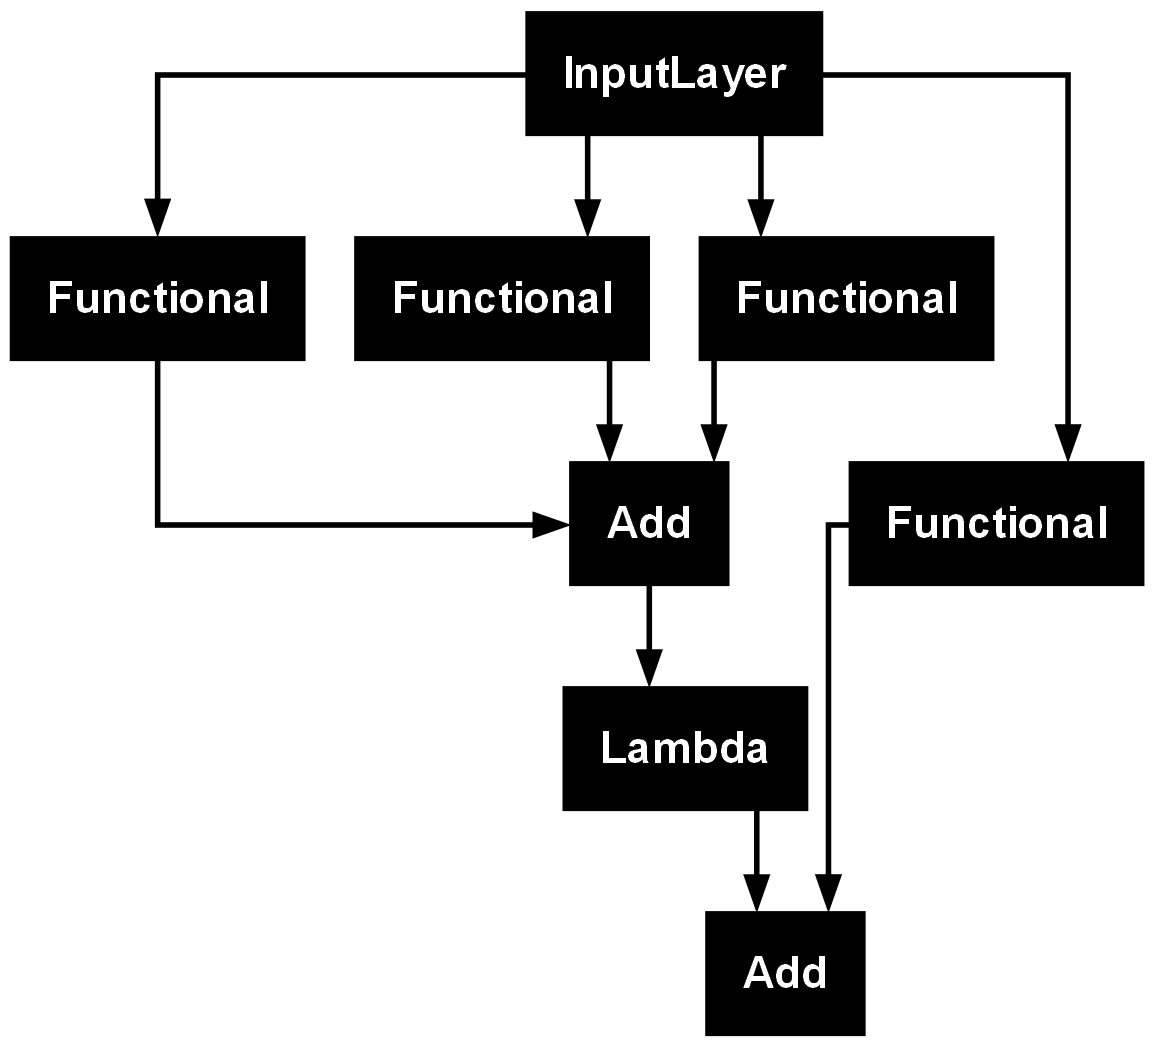

In [4]:
multiwave_model = SineNN(X_train, y_train, waves=[1, 1/2, 1/3], learning_rate=0.1)()
tf.keras.utils.plot_model(multiwave_model)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


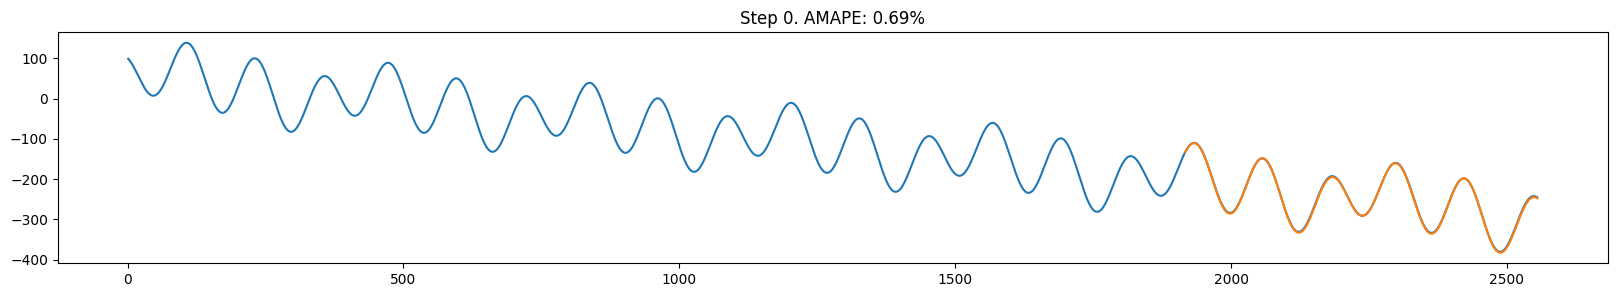

In [5]:
for step in range(1):
  multiwave_model.fit(
      X_train,
      y_train,
      epochs=50,
      verbose=False
      )
  y_pred = multiwave_model.predict(X_test)
  amape =  amape_score(y_test, y_pred, reference=y_train)
  fig = plt.figure(figsize=(20,3))
  plt.plot(X.flatten(), y)
  plt.plot(X_test.flatten(), y_pred)
  plt.title(f'Step {step}. AMAPE: {amape:.2f}%')
  plt.show()

In [6]:
multiwave_model.weights

[<KerasVariable shape=(1, 1), dtype=float32, path=phase_shift_1/kernel>,
 <KerasVariable shape=(1, 1), dtype=float32, path=frequency_1/kernel>,
 <KerasVariable shape=(1, 1), dtype=float32, path=phase_shift_amplifier_1/kernel>,
 <KerasVariable shape=(1, 1), dtype=float32, path=sin_1/kernel>,
 <KerasVariable shape=(1, 1), dtype=float32, path=amplitude_1/kernel>,
 <KerasVariable shape=(1, 1), dtype=float32, path=phase_shift_2/kernel>,
 <KerasVariable shape=(1, 1), dtype=float32, path=frequency_2/kernel>,
 <KerasVariable shape=(1, 1), dtype=float32, path=phase_shift_amplifier_2/kernel>,
 <KerasVariable shape=(1, 1), dtype=float32, path=sin_2/kernel>,
 <KerasVariable shape=(1, 1), dtype=float32, path=amplitude_2/kernel>,
 <KerasVariable shape=(1, 1), dtype=float32, path=phase_shift_3/kernel>,
 <KerasVariable shape=(1, 1), dtype=float32, path=frequency_3/kernel>,
 <KerasVariable shape=(1, 1), dtype=float32, path=phase_shift_amplifier_3/kernel>,
 <KerasVariable shape=(1, 1), dtype=float32, pa

## Automatically generated relative wavelengths

Model: "SineNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 1)         │       0 │ -                    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ Wave_1 (Functional) │ (None, 1)         │       5 │ input[0][0]          │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ Wave_2 (Functional) │ (None, 1)         │       5 │ input[0][0]          │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ Wave_3 (Functional) │ (None, 1)         │       5 │ input[0][0]          │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ Wave_4 (Functional) │ (None, 1)         │       5 │ input[0][0]          │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ Wave_5 (Functional) │ (None, 1)         │       5 │ input[0][0]          │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ Wave_6 (Functional) │ (None, 1)         │       5 │ input[0][0]          │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ Wave_7 (Functional) │ (None, 1)         │       5 │ input[0][0]          │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ add_waves (Add)     │ (None, 1)         │       0 │ Wave_1[0][0],        │
│                     │                   │         │ Wave_2[0][0],        │
│                     │                   │         │ Wave_3[0][0],        │
│                     │                   │         │ Wave_4[0][0],        │
│                     │                   │         │ Wave_5[0][0],        │
│                     │                   │         │ Wave_6[0][0],        │
│                     │                   │         │ Wave_7[0][0]         │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ Trend (Functional)  │ (None, 1)         │       4 │ input[0][0]          │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ waves_output        │ (None, 1)         │       0 │ add_waves[0][0]      │
│ (Lambda)            │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ output (Add)        │ (None, 1)         │       0 │ Trend[0][0],         │
│                     │                   │         │ waves_output[0][0]   │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 39 (156.00 B)

 Trainable params: 25 (100.00 B)

 Non-trainable params: 14 (56.00 B)

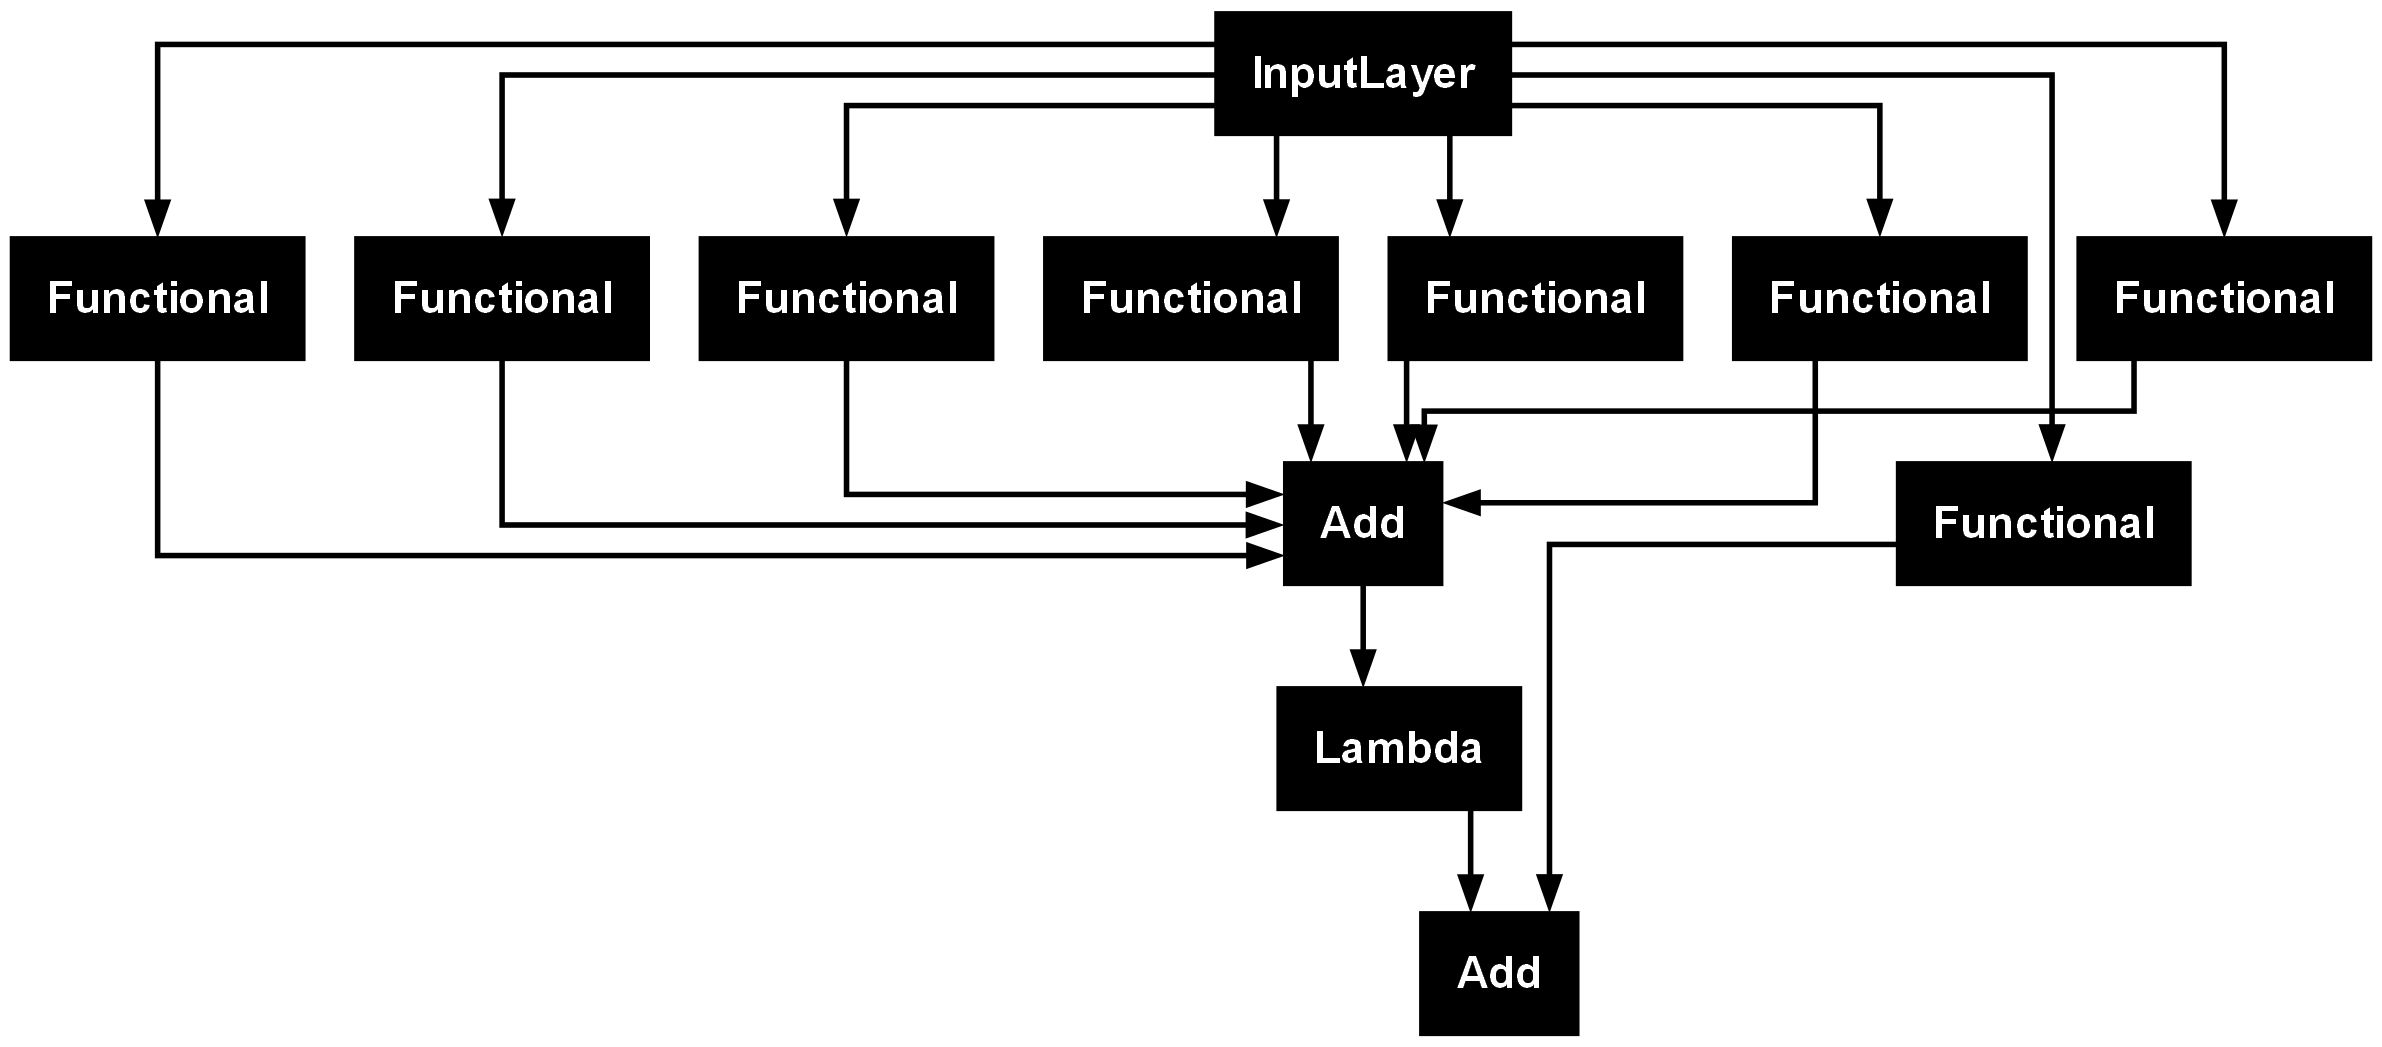

In [8]:
waves = auto_n_relative_wavelengths(7)
multiwave_model = SineNN(X_train, y_train, waves=waves, learning_rate=0.1)()
tf.keras.utils.plot_model(multiwave_model)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


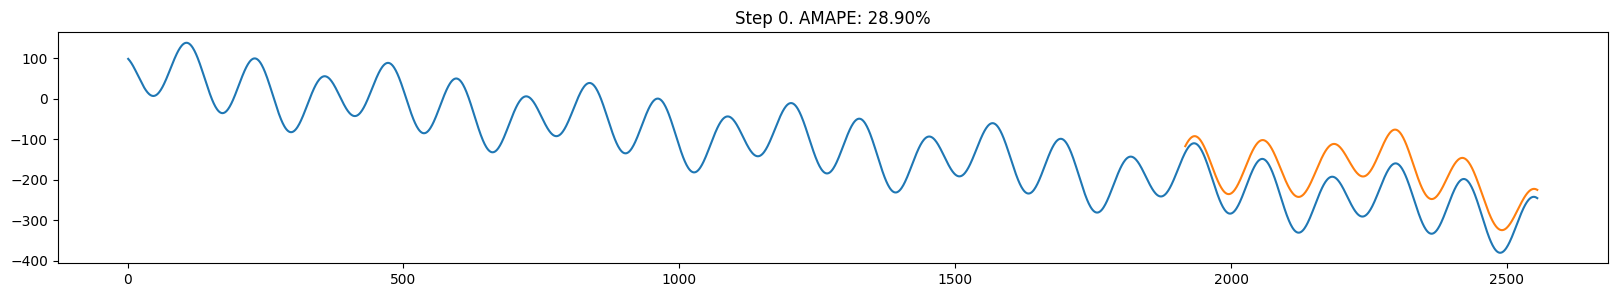

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


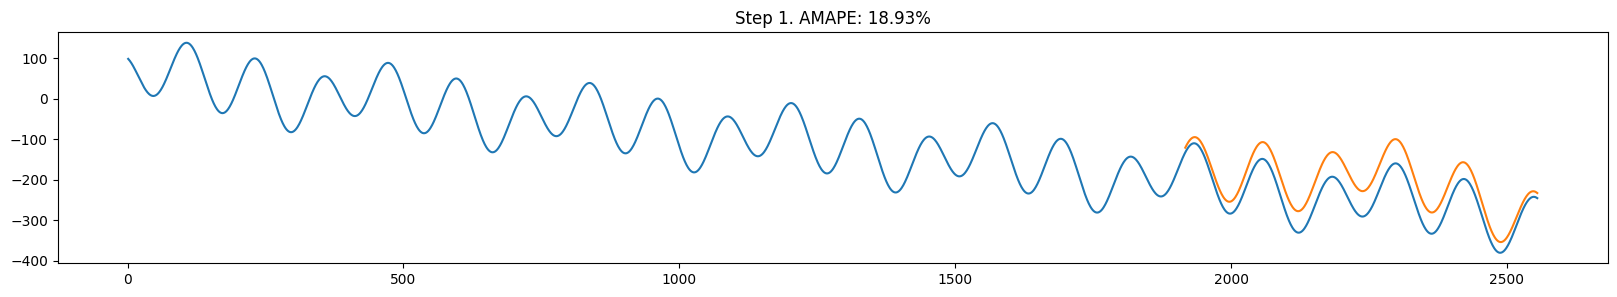

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


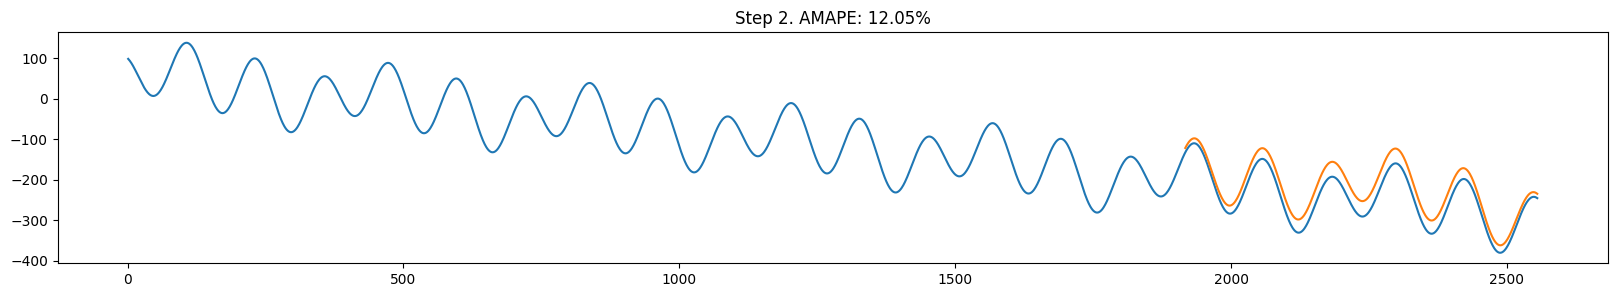

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


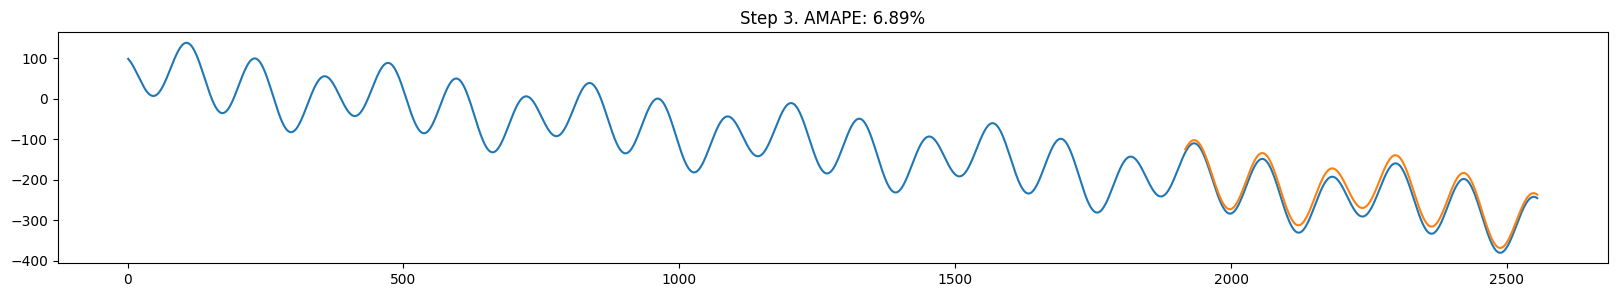

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


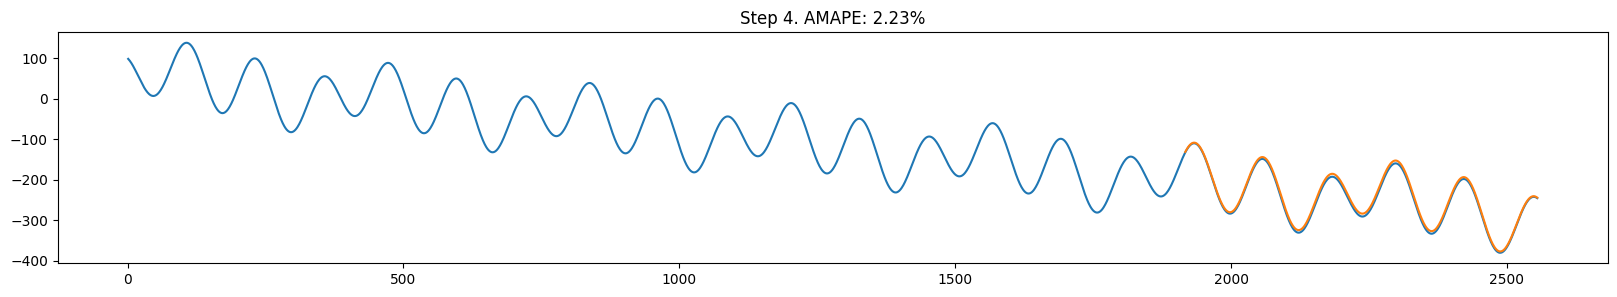

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


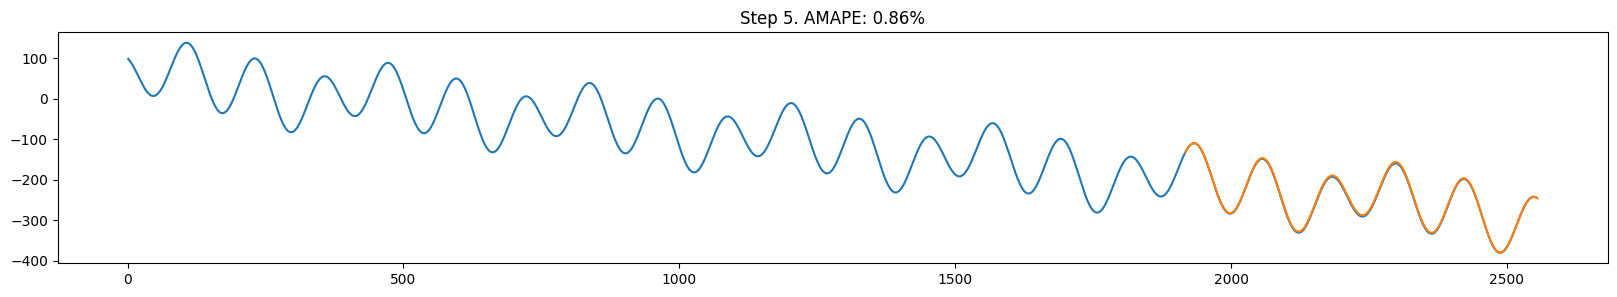

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


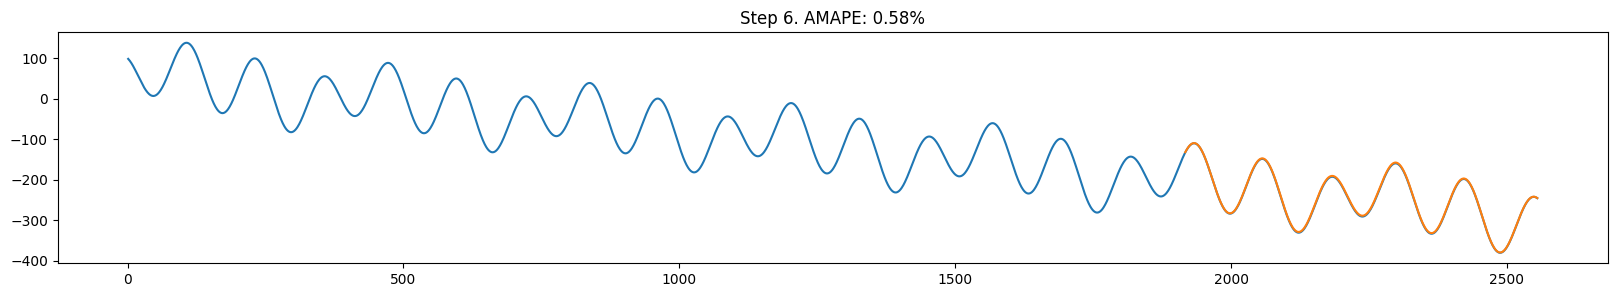

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


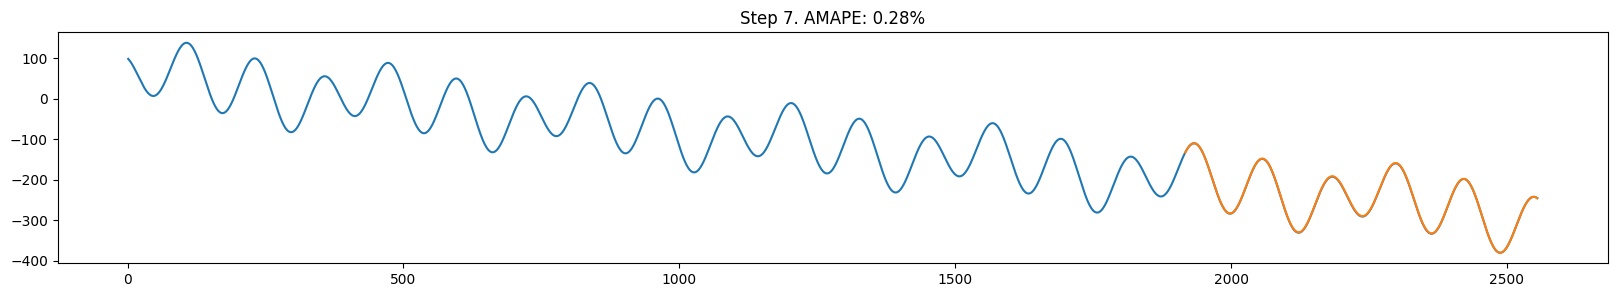

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


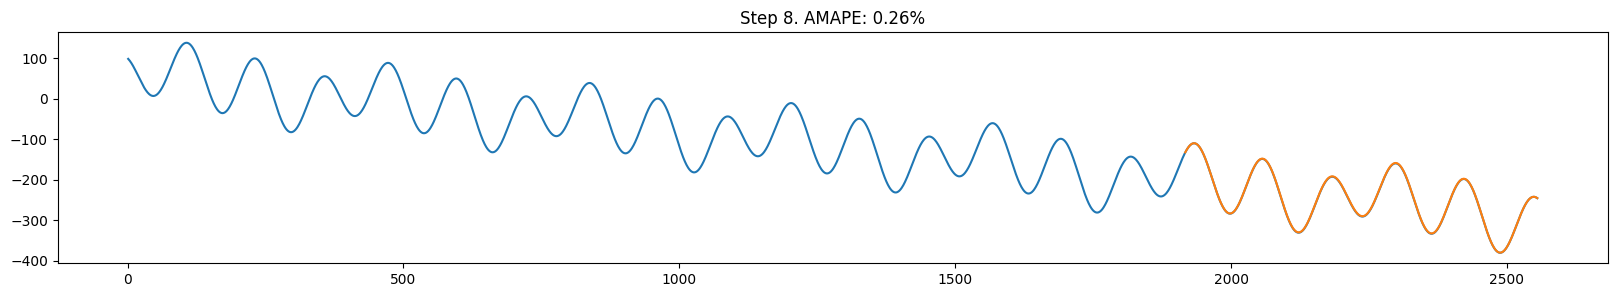

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


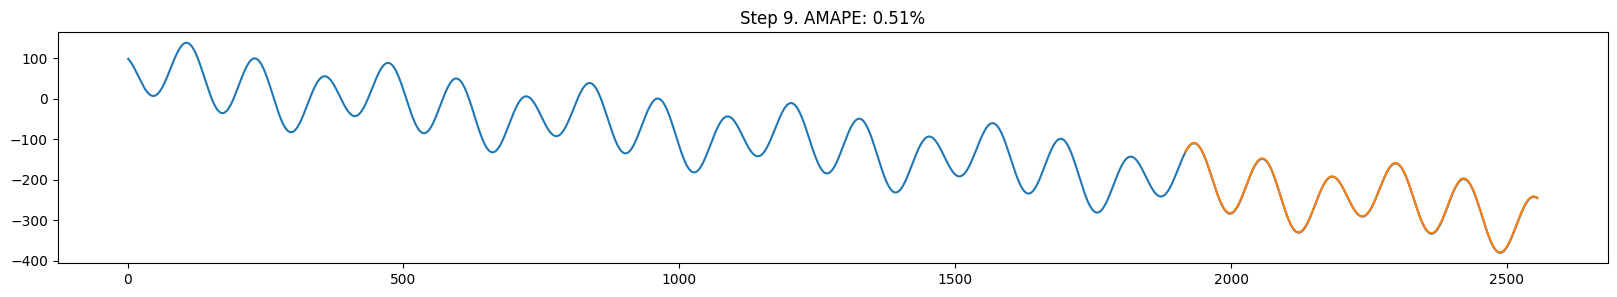

In [9]:
target_amape = 0.1
for step in range(10):
  multiwave_model.fit(
      X_train,
      y_train,
      epochs=50,
      verbose=False
      )
  y_pred = multiwave_model.predict(X_test)
  amape =  amape_score(y_test, y_pred, reference=y_train)
  fig = plt.figure(figsize=(20,3))
  plt.plot(X.flatten(), y)
  plt.plot(X_test.flatten(), y_pred)
  plt.title(f'Step {step}. AMAPE: {amape:.2f}%')
  plt.show()
  if amape <= target_amape:
    break